# Numerical instability mitigations in BSSN equations

### Miro Palmu, 976503

## Introduction

Einstein field equations are set of equations which define how structure of space time depends on it's matter content and vise versa. There exist multiple exact solutions for these including Kerr spacetime which describes a rotating black hole. However, in dynamic situations (e.g. black hole collisions) one has to solve the equations numerically. Unfortunately the equations are notoriously unstable and successfully solving them requires a great deal of care [1, 2, 3]. In this project we inspect the effects of different techniques used to mitigate instabilities in 1D numerical relativity simulation. The work is based on attempt to reproduce results from [4].

## ADM equations

In general relativity spacetime is described by the 4 dimensionl metric tensor $g_{\mu\nu}$. It's geometric meaning can be interperted from the line element:

\begin{align}
ds^2 = g_{\mu\nu}dx^\mu dx^\nu
\end{align}

Here we use Einstein summation convention in which repeated indices are summed over. By convention greek indices range from 0 to 3 and in later equation latin indices range from 1 to 3.

Inorder to solve metric numerically we have to split the spacetime into 3 dimensional spatial slices. This can be done by using ADM formalism which line element is [5]:

\begin{align}
ds^2 = -\alpha^2 dt^2 + \gamma_{ij}(dx^i + \beta^i dt)(dx^j + \beta^j dt)
\end{align}

where $\gamma_{ij} = g_{ij}$ is the spatial metric tensor of the spatial spacetime slice, $\beta_i = g_{0i}$ is shift and $\alpha=\sqrt{-g_{00} + \beta^n \beta_n}$ is lapse. These are not enough hold all the information from the full spacetime metric. We need extrinsic curvature $K_{ij}= \frac1{2\alpha}(D_i\beta_j + D_j\beta_i - \partial_t\partial g_{ij})$ where $D$ represents covariant derivative associated with $\gamma_{ij}$. Note that shift and lapse are gauge variables which require a gage to be chosen.

With these we could write down equations of motions for spatial metric and extrinsic curvature. Then we could pick gauge for shift and lapse, pick some initial spatial slice and start numerically integrate them. However, ADM equations are inherently unstable and there is no point in doing this.

## BSSN equations

In order to make equations of motion stable we have to go to BSSN formalism. Specificly we will use $W^2$ conformal decomposition. For brievity we will omit the details and just state the BSSN variables in terms of ADM variables:


\begin{align}
\tilde{\gamma}_{ij} &= W^2 \gamma_{ij} \\
\tilde{A}_{ij} &= W^2(K_{ij} - \frac13 \gamma_{ij}K) \\
K &= \gamma^{nm}K_{nm} \\
W &= \det(\gamma)^{-1/6} \\
\tilde{\Gamma}^i &= \tilde{\gamma}^{nm} \tilde{\Gamma}^i_{nm} \\
\alpha_{bssn} &= \alpha_{adm} \\
\beta^i_{bssn} &= \beta^i_{adm}
\end{align}

where $\tilde{\Gamma}^i_{nm}$ are the Christoffel symbols of 2nd kind associated with $\tilde{\gamma}_{ij}$.

Now we can write BSSN equations of motions [4]:

![bssn equations of motion](./bssn.png)

where TF refes to trace free and for value $Q_{ij}$ it is calculated as $Q_{ij}^{TF} = Q_{ij} - \frac 13 \tilde{\gamma}_{ij}Q^a_a$

We will use harmonic gauge or harmonic slicing with 0 shift:

\begin{align}
\partial_t \alpha &= -\alpha^2 K + \beta^m \partial_m \alpha \\
\beta^i &= 0
\end{align}

Inorder BSSN formalism to be well posed there are number of constraints that must be satisfied. Firstly there are algebraic constraints:

\begin{align}
\det(\tilde{\gamma}) - 1 = 0 \\
\tilde{\gamma}^{nm} \tilde{A}_{nm} = 0
\end{align}

Then there are Momentum, Hamiltonian and Christoffel symbol constraints:

\begin{align}
M_i &=  \tilde{\gamma}^{nm}  \tilde{D}_m \tilde{A}_{ni} - \frac23 \partial_i K - \frac32 \tilde{A}^m_i \partial_m(W^2) W^{-2} = 0\\
H &= R^i_j + \frac23 K^2 -\tilde{A}^{nm}\tilde{A}_{nm} = 0 \\
\xi ^i &= \tilde{\Gamma}^i - \tilde{\gamma}^{nm}\tilde{\Gamma}^i_{nm} = 0
\end{align}

In this project we will focus on momentum and Hamiltonian constraints and ignore the Christoffel symbol constraint.

## Numerical methods

### Grid

The simulation grid used is N x 1 x 1 unifrom grid with periodic boundary conditions such that x coordinate is bound to unit interval or $x_i = \frac{i}{N}$.

### Finite difference

Following finite difference methods were used to calculate required derivatives:

Central 6th order accurate 1st derivative:

\begin{align}
\frac{\partial f}{\partial x}(x_i) = \frac{1}{h}\left( \frac{1}{12} f(x_{i-2}) + \frac{2}{3} f(x_{i-1}) + \frac{2}{3} f(x_{i+1}) - \frac{1}{12} f(x_{i+2}) \right)
\end{align}

Central 2th order accurate 6th derivative:

\begin{align}
\frac{\partial^6 f}{\partial x^6}(x_i) = \frac{1}{h^6}\left( f(x_{i-3})-6 f(x_{i-2})+15 f(x_{i-1})-20 f(x_{i})+15 f(x_{i+1})-6 f(x_{i+2})+f(x_{i+3})\right)
\end{align}

### Integrator

BSSN equations are stiff meaning that we can not use explicit integratiors. We have to use implicit ones and following [4] we use backwards euler method:

\begin{align}
f(t + dt) = f(t) + dt f(t + dt)
\end{align}

From this we solve $f(t + dt)$ with fixed point iteration. For backwards euler this means that:

\begin{align}
f_{k+1}(t + dt) = f_0(t) + dt \partial_t f_{k}(t + dt)
\end{align}

where the subscript referes the iteration ordinal. $f_0$ is the initial value and the iteration is repeated some specified amount.

## Numerical instability mitigations
### Algebraic constraints

Algebraic constraints can be directly enforced on each substep of backwards euler:

\begin{align}
\tilde{\gamma}_{ij} &= \frac{\tilde{\gamma}_{ij}}{\det(\tilde{\gamma})^{1/3}} \\
\tilde{A}_{ij} &= \tilde{A}^{TF}_{ij}
\end{align}

### Clamping $W$

In BSSN equations with $W^2$ conformal decomposition $W$ might tend towards $0$.
This is a problem because the equations of motion contain term involving $\frac{\alpha}{W}$.
Technically, $\alpha$ is expected to tend to $0$ faster than $W$ which makes the fraction regular [4].
However, numerically this is a problem and has to be prevented. In the simulation at the beginning of each step we clamp $W$ to be above $0.0001$.

### Damping momentum constraint

Deviations from $M_i = 0$ can be mitigated by adding a damping term to $\partial_t \tilde{A}_{ij}$:

\begin{align}
\partial_t \tilde{A}_{ij} = \partial_t \tilde{A}_{ij} + k_m \alpha \tilde{D}_{(i}M_{j)}
\end{align}

### Kreiss-Oliger dissipation

Kreiss-Oliger dissipation [6] is a way to remove certain order of frequensies from the simulation by damping them. It is defined as:

\begin{align}
\partial_t f = \partial_t f + (-1)^{(p+3)/2} \epsilon \frac{h^p}{2^{p+1}}\left( \frac{\partial^{p+1}}{\partial x^{p+1}} + \frac{\partial^{p+1}}{\partial y^{p+1}} + \frac{\partial^{p+1}}{\partial z^{p+1}} \right)f
\end{align}

We will use $p=5$:

\begin{align}
\partial_t f = \partial_t f + \epsilon \frac{h^5}{64}\left( \frac{\partial^{6}}{\partial x^{6}} + \frac{\partial^{6}}{\partial y^{6}} + \frac{\partial^{6}}{\partial z^6} \right)f
\end{align}

We apply this as a post processing step for the last backwards euler substep.

## Initial conditions

To initialize BSSN variables we can use known analytic solutions to Einstein field equations (i.e. analytic metric) at some spatial slice to first initialize ADM variables and then BSSN variables.

### Minkowski spacetime

Minkowski spacetime describes a flat spacetime. Here is the line element of it written in terms of cartesian coordinates:

\begin{align}
ds^2 = -dt^2 + dx^2 + dy^2 + dz^2
\end{align}

Our initial spatial slice is $t=0$.

These coordinates trivially fulfill the harmonic gauge conditions with zero shift.

### Gauge wave

Gauge wave spacetime is Minkowski spacetime but expressed in periodic coordinates which exploit gauge freedom to produce propagating wave in the line element [3]. Despite the simplicity gauge wave is a great test for stability of numerical relativity simulation. Gauge wave line element is:

\begin{align}
ds^2 = (1-B)(-dt^2 + dx^2) + dy^2 + dz^2
\end{align}

where

\begin{align}
B = 10^{-1} \sin\left(\frac{2\pi(x-t)}{d}\right)
\end{align}

Our initial slice is $t=0$.

Gauge wave coordinates can be show to fulfill harmonic gauge conditions (not done here for brevity).

## Output format

Output from the simulation is written to directory called *output* with following structure:

```
<output-dir>/
├── g11.txt
├── hamiltonian_inf_norm.txt
├── log
├── momentum_inf_norm.txt
├── steps
├── lapse.txt
└── time.txt
```

`g11.txt`: spatial metric $\gamma_{11}$ at every grid point.

`hamiltonian_inf_norm.txt`: $max(|H|)$ at each time step.

`log`: information about the run.

`momentum_inf_norm.txt`: $max(|M_i|)$ at each time step.

`steps`: runtime of each calculated time step and marks at which points dumps were created.

`time.txt`: time coordinates at each time step.

`lapse.txt`: lapse $\alpha$ at every grid point

For more information about the simulation, see `README.md`.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [92]:
def read_output(output_dir_path):
    """
    Args:
        output_dir_path (str): The path to the output directory.

    Returns:
        ndarray: elapsed time t_i.
        ndarray: hamiltonian inf norm
        ndarray: momentum inf norm
        ndarray: metric g11 at every i:th grid cell.
        ndarray: lapse alpha at every i:th grid cell.
    """

    time_arr = np.loadtxt(output_dir_path + "/time.txt")
    H_arr = np.loadtxt(output_dir_path + "/hamiltonian_inf_norm.txt")
    M_arr = np.loadtxt(output_dir_path + "/momentum_inf_norm.txt")
    g11_arr = np.loadtxt(output_dir_path + "/g11.txt")
    lapse_arr = np.loadtxt(output_dir_path + "/lapse.txt")

    return time_arr, H_arr, M_arr, g11_arr, lapse_arr

### Plotting

Here is functions that we use to analyze outputs. We plot Hamiltonian and momentum infinity norms as function of time. As coordinate independent measurements, these function as the main way to analyze the numerical stability of the simulation.

We also use heatmaps to visualize lapse $\alpha$ and spatial metric component $\gamma_{11}$ at every grid point through out the runs. Along side these are the analytical values. Note that unlike the constraints, these are coordinate dependent values. Their deviations from analytical values is not meaningful metric. Their plots provide only qualitative information about the simulation.

In [93]:
def minkowski_g11(t_arr, x_arr):
    assert len(t_arr.shape) == 1
    assert len(x_arr.shape) == 1
    
    return np.ones((len(t_arr), len(x_arr)))

def minkowski_lapse(t_arr, x_arr):
    assert len(t_arr.shape) == 1
    assert len(x_arr.shape) == 1
    
    return np.ones((len(t_arr), len(x_arr)))

def gauge_wave_lapse(t_arr, x_arr):
    assert len(t_arr.shape) == 1
    assert len(x_arr.shape) == 1

    t_2arr = t_arr[:, np.newaxis]
    x_2arr = x_arr[np.newaxis, :]

    # Wavelength set to simulation width
    # assuming simulation x coordinates are 0, ..., N - 1
    N = len(x_arr)
    d = 1
    A = 0.1
    
    H = A * np.sin(2 * np.pi * (x_2arr - t_2arr) / d)
    
    return np.sqrt(1 - H)

def gauge_wave_g11(t_arr, x_arr):
    assert len(t_arr.shape) == 1
    assert len(x_arr.shape) == 1

    t_2arr = t_arr[:, np.newaxis]
    x_2arr = x_arr[np.newaxis, :]

    # Wavelength set to simulation width
    # assuming simulation x coordinates are 0, ..., N - 1
    N = len(x_arr)
    d = 1
    A = 0.1
    
    H = A * np.sin(2 * np.pi * (x_2arr - t_2arr) / d)
    
    return 1 - H

In [94]:
def plot_output(output_dir_path, g11_theory, lapse_theory):
    t_arr, H_arr, M_arr, g11_arr, lapse_arr = read_output(output_dir_path)
    
    fig, ((H_ax, M_ax), (lapse_ax, lapse_theory_ax), (g11_ax, g11_theory_ax)) = plt.subplots(3, 2, figsize=(10, 10))

    # Assume grid points (i, j, k) are at coordinates (i, j, k)
    # and that j == k == 0.
    N = len(g11_arr[0, :])
    x_arr = np.linspace(0, 1, N, endpoint=False)

    H_ax.plot(t_arr, H_arr, label="Hamiltonian sum")
    M_ax.plot(t_arr, M_arr, label="Momentum sum")

    lapse_min = None # 0.94
    lapse_max = None # 1.06

    lapse_img = lapse_ax.pcolormesh(x_arr, t_arr, lapse_arr, vmin=lapse_min, vmax=lapse_max)
    lapse_cbar = fig.colorbar(lapse_img)
    
    lapse_theory_arr = lapse_theory(t_arr, x_arr)

    lapse_theory_img = lapse_theory_ax.pcolormesh(x_arr, t_arr, lapse_theory_arr, vmin=lapse_min, vmax=lapse_max) 
    lapse_theory_cbar = fig.colorbar(lapse_theory_img)

    g11_min = None # 0
    g11_max = None # 1.1
    
    g11_img = g11_ax.pcolormesh(x_arr, t_arr, g11_arr, vmin=g11_min, vmax=g11_max)
    g11_cbar = fig.colorbar(g11_img)
    g11_theory_arr = g11_theory(t_arr, x_arr)

    g11_theory_img = g11_theory_ax.pcolormesh(x_arr, t_arr, g11_theory_arr, vmin=g11_min, vmax=g11_max) 
    g11_theory_cbar = fig.colorbar(g11_theory_img)

    H_ax.set(xlabel="t",
             ylabel="$||H||_\\infty$")
    M_ax.set(xlabel="t",
             ylabel="$||M_i||_\\infty$")

    lapse_ax.set(xlabel="x",
                 ylabel="t")
    lapse_theory_ax.set(xlabel="x",
                        ylabel="t")

    g11_ax.set(xlabel="x",
               ylabel="t")
    g11_theory_ax.set(xlabel="x",
                      ylabel="t")

    lapse_cbar.ax.set_ylabel("$\\alpha$", rotation=90)
    lapse_theory_cbar.ax.set_ylabel("$\\alpha \\text{ analytical}$", rotation=90)

    
    #g11_cbar.ax.get_yaxis().labelpad = 15
    g11_cbar.ax.set_ylabel("$\\gamma_{11}$", rotation=90)
    
    #g11_theory_cbar.ax.get_yaxis().labelpad = 15
    g11_theory_cbar.ax.set_ylabel("$\\gamma_{11}\\text{ analytical}$", rotation=90)

    fig.suptitle(pathlib.Path(output_dir_path).stem)
    fig.tight_layout()

## Simulation runs

In this section we solve BSSN equations using methods described above with the simulation (`main` executable, see `README.md`).

Simulations use following values from [4] with varying total number of time steps:

```
grid size: 128 x 1 x 1
dt: 0.001
implicit euler substeps: 2
W clamp: 1e-04
momentum damping coeff (km): 0.025
Kreiss-Oliger coeff (epsilon): 0.25
output interval (% of total steps): 10
```

First we analyze Minkowski run with 40000 time steps and gauge wave run with 10000 and 40000 time steps. After these there are gauge wave runs which have one of the numerical instability mitigations disabled.

### Minkowski run

This is trivial spacetime but it funcions as a test that the simulation does not do anything obivously wrong. 

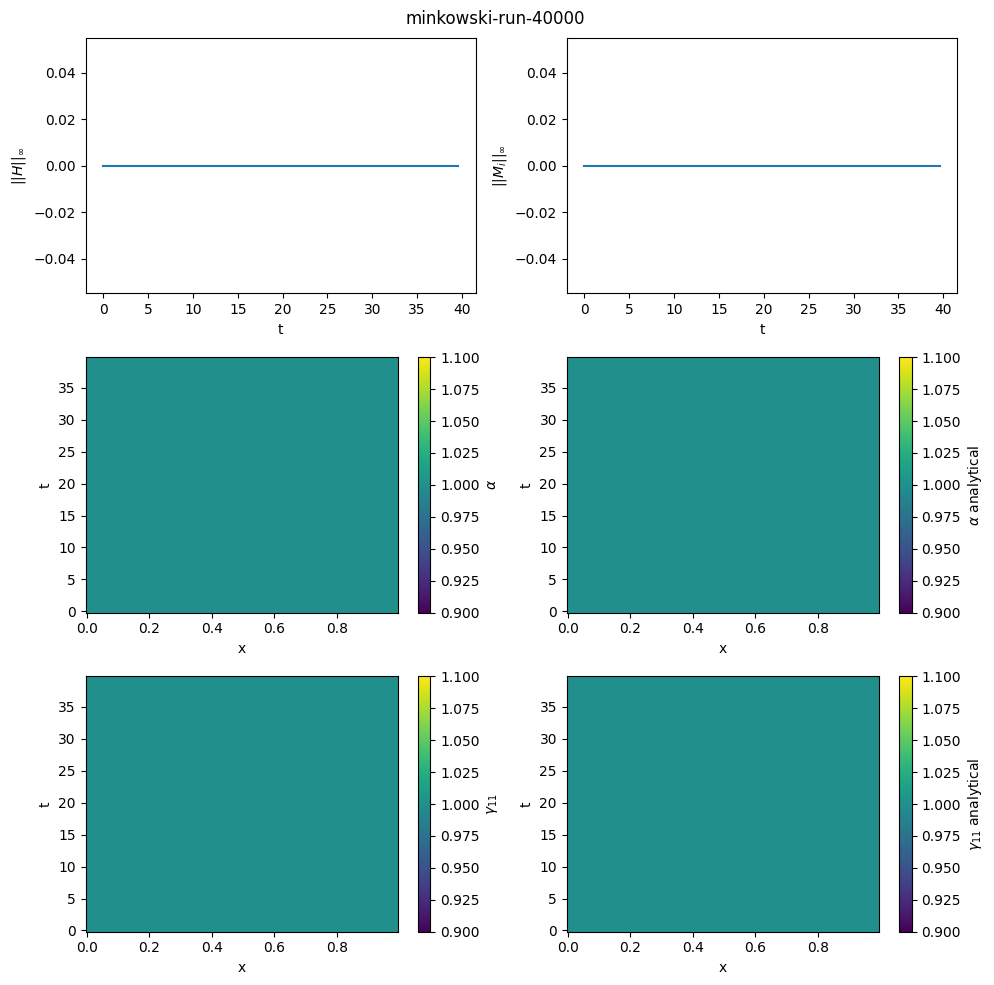

In [103]:
plot_output("/home/pamiro/repos/computational_physics_project/data/minkowski-run-40000", minkowski_g11, minkowski_lapse)

We can see that momentum and Hamiltonian constraints stay at zero as expected. Additionally $\alpha = \gamma_{11} = 1$ stays true throughout the run, as they should.

### Gauge wave

There are two runs. First is 10000 time steps long and the second is 40000 steps long.

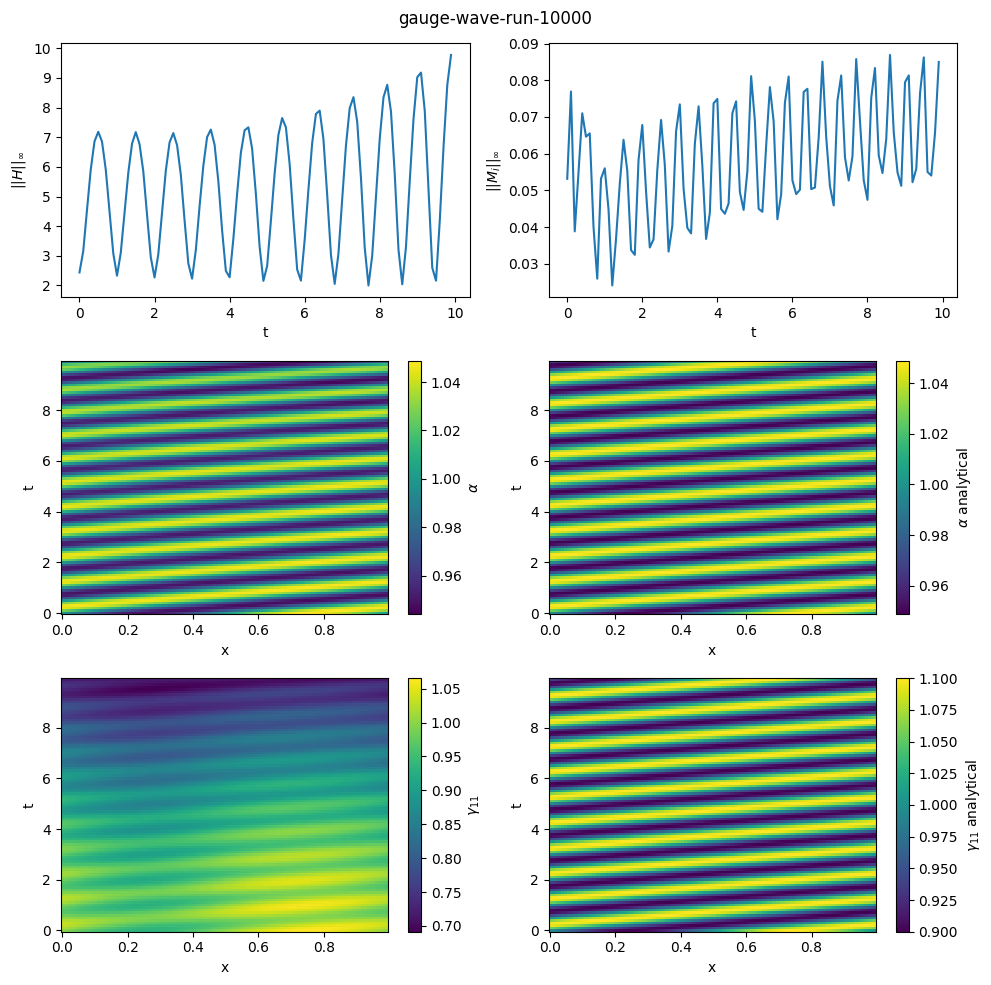

In [96]:
plot_output("/home/pamiro/repos/computational_physics_project/data/gauge-wave-run-10000", gauge_wave_g11, gauge_wave_lapse)

We can see that the constraints oscillate with increasing amplitude. Importantly they do not explode in the first 10 units of time.

From lapse and $\gamma_{11}$ we can see that the gauge wave propagates similarly to analytical solutions but $\gamma_{11}$ loses amplitude.

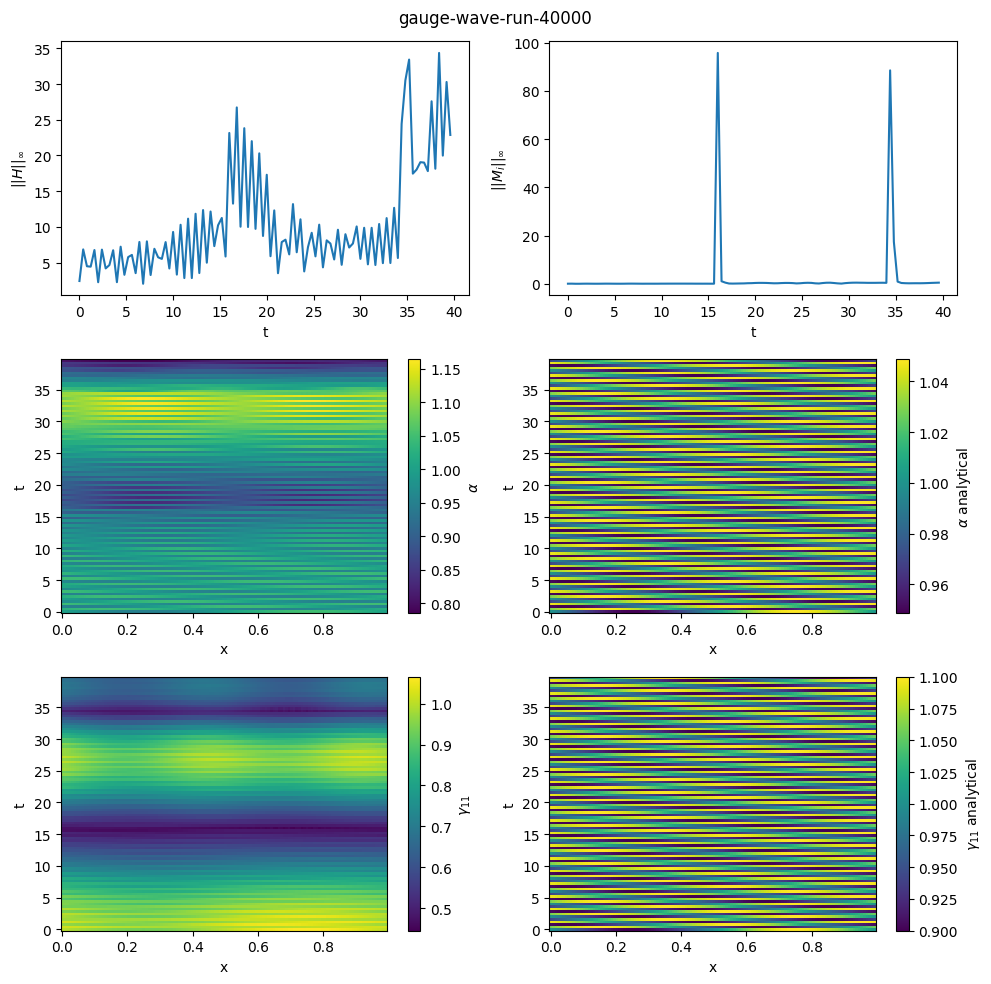

In [97]:
plot_output("/home/pamiro/repos/computational_physics_project/data/gauge-wave-run-40000", gauge_wave_g11, gauge_wave_lapse)

By increasing time steps to 40000 we evolve the simulation long enough that $\gamma_{11}$ wave amplitude is small enough to cause spikes in both constraints. Interestingly the simulation seems to recover from this and gauge wave continues propagating.

Timing for this explosion $\sim 15$ matches what is reported in figure 1 (BSSNOK line) of [3].

### Gauge wave without enforcing algebraic constraints

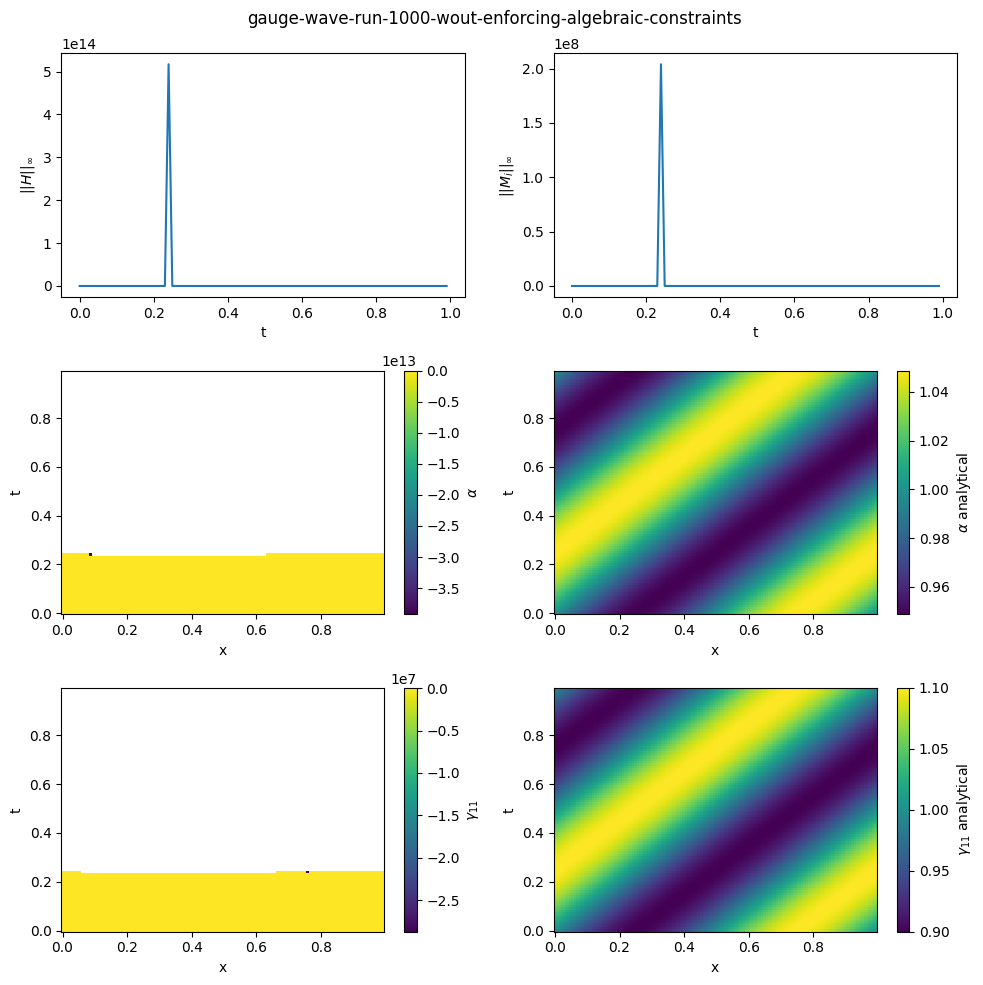

In [98]:
plot_output("/home/pamiro/repos/computational_physics_project/data/gauge-wave-run-1000-wout-enforcing-algebraic-constraints", gauge_wave_g11, gauge_wave_lapse)

By not enforcing the algebraic constraints the Hamilton and momentum constraints explode immediatly at $\sim 0.2$ and there is no recovery from this. White in heatmaps indicate NaNs. This confirms the importance of enforcing algebraic constraints. 

### Gauge wave without clamping $W$

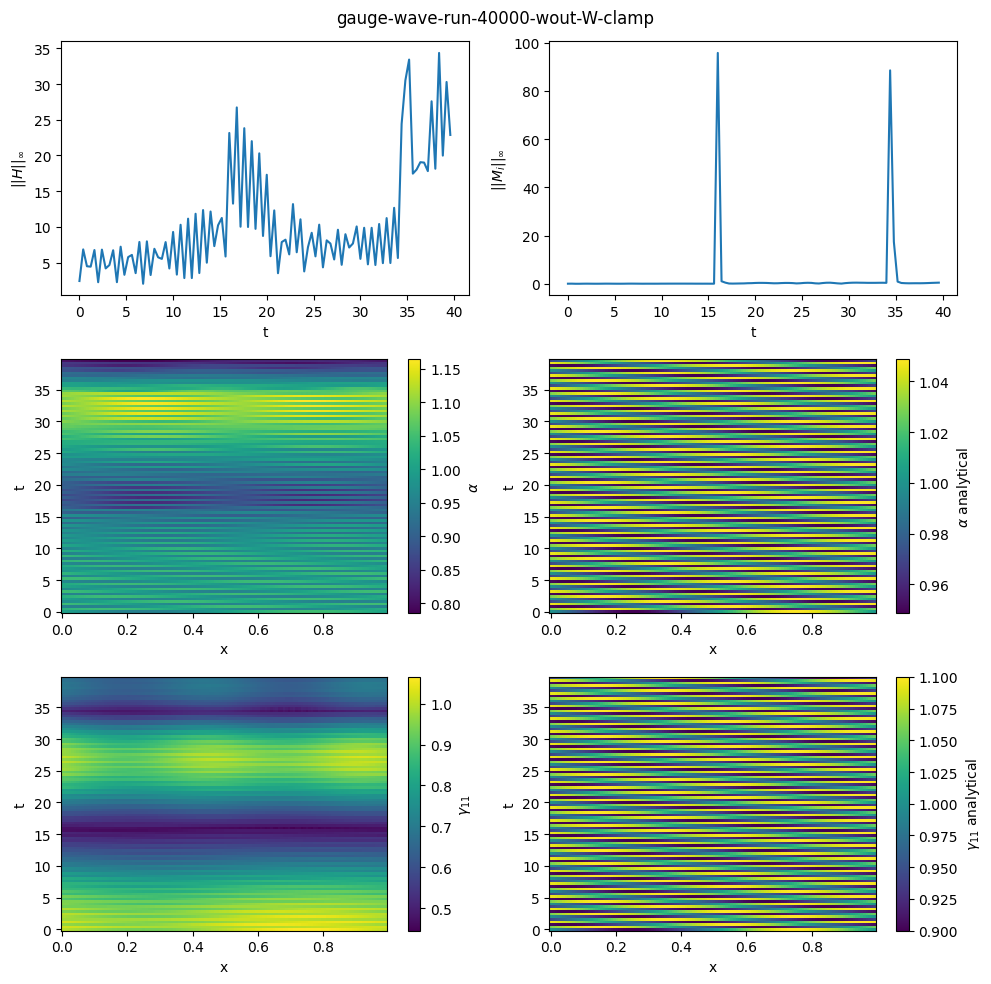

In [99]:
plot_output("/home/pamiro/repos/computational_physics_project/data/gauge-wave-run-40000-wout-W-clamp", gauge_wave_g11, gauge_wave_lapse)

This run is equivelant to `gauge-wave-run-40000`. This indicates that $W$ falling towards zero is not problem for gauge wave.

### Gauge wave without damping momentum constraint

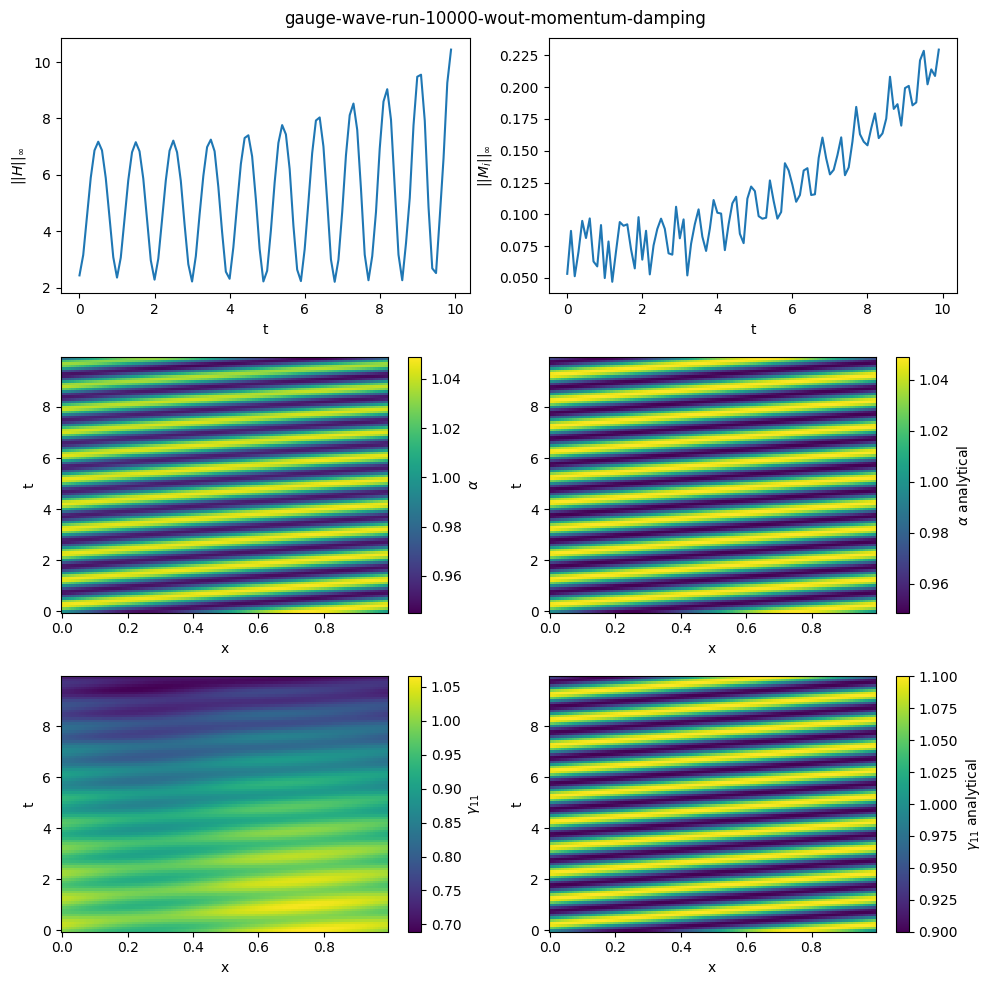

In [100]:
plot_output("/home/pamiro/repos/computational_physics_project/data/gauge-wave-run-10000-wout-momentum-damping", gauge_wave_g11, gauge_wave_lapse)

Compared to `gauge-wave-run-10000` momentum constraint increases much faster. There is not noticable difference in lapse $\alpha$ or $\gamma_{11}$.

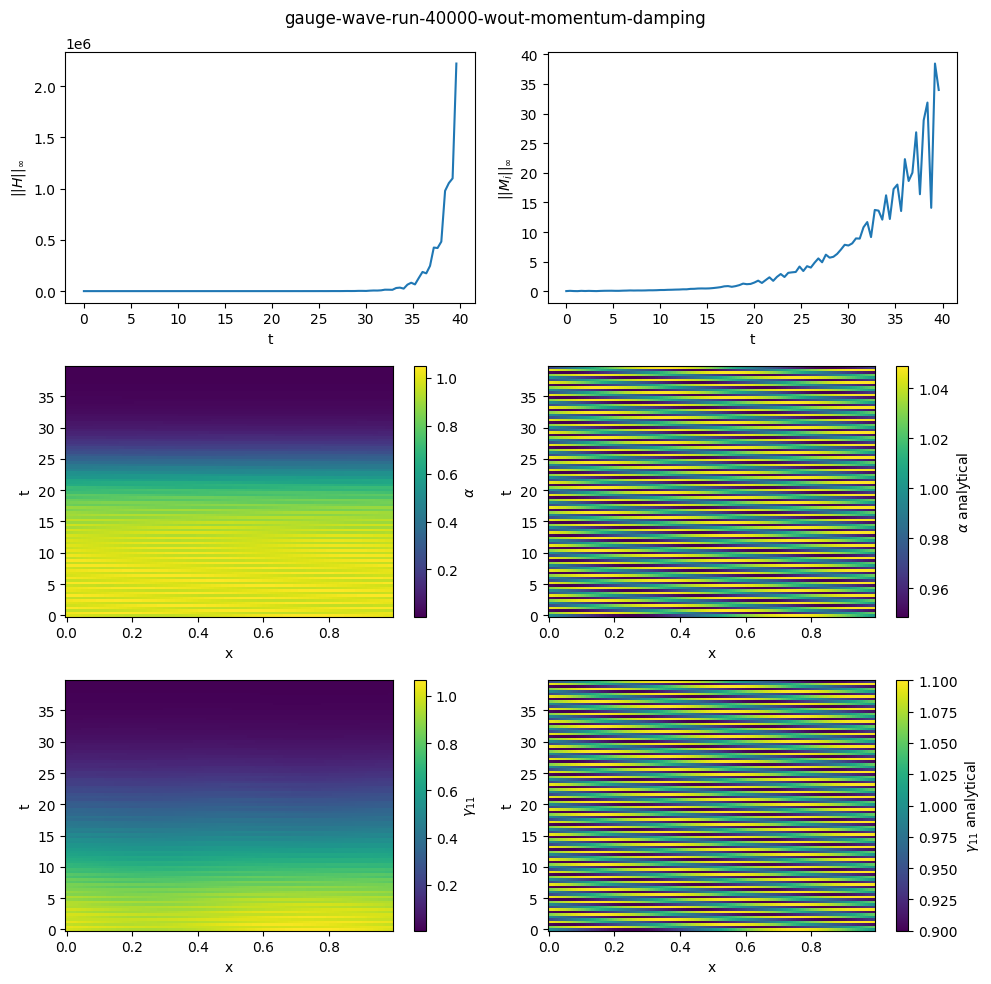

In [101]:
plot_output("/home/pamiro/repos/computational_physics_project/data/gauge-wave-run-40000-wout-momentum-damping", gauge_wave_g11, gauge_wave_lapse)

At the end of the simulation constraints grow exponentially. Comparing to `gauge-wave-run-40000` we can learn
about the effects of momentum constraint damping. Interestingly there are no spikes in the constraints but overall they are much larger.
This implies that momentum constraint damping is the reason for the recovery in `gauge-wave-run-40000`.
Also, without the damping lapse $\alpha$ gauge wave loses amplitude similarly to $\gamma_{11}$.

### Gauge wave without Kreiss-Oliger dissipation

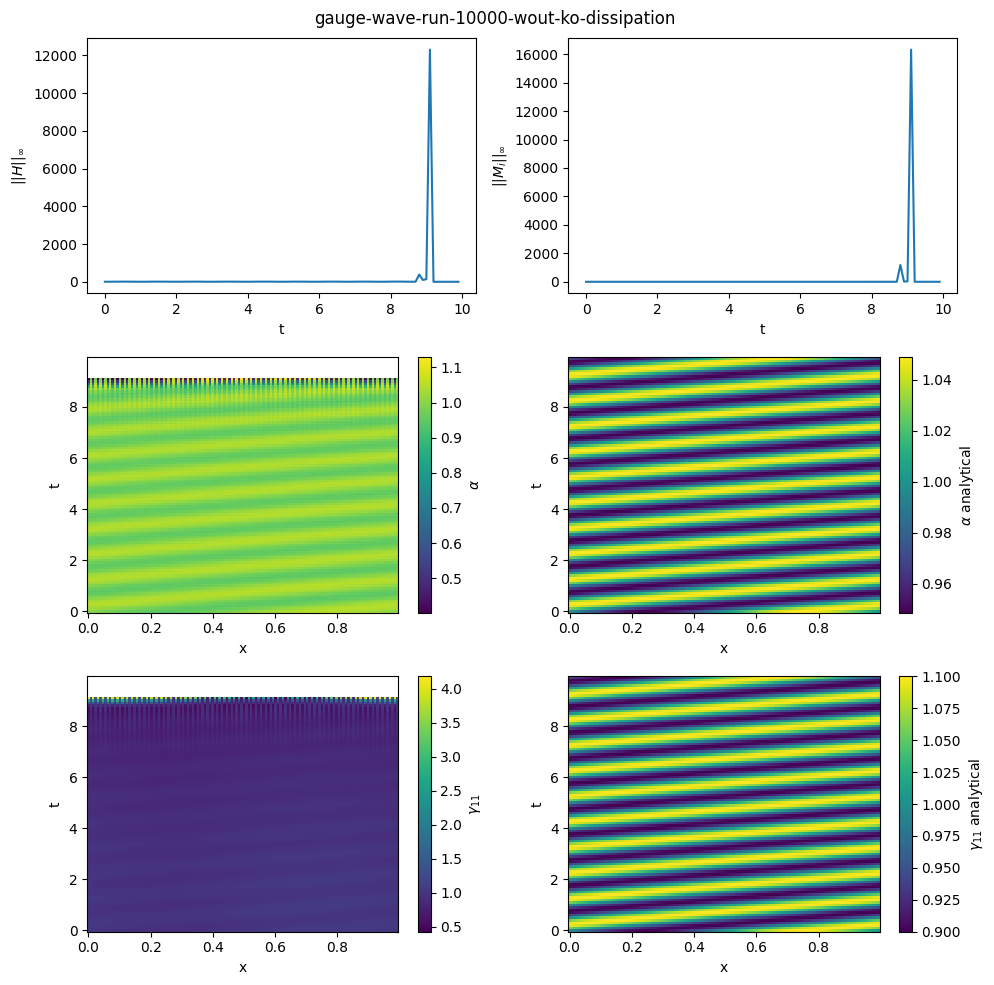

In [102]:
plot_output("/home/pamiro/repos/computational_physics_project/data/gauge-wave-run-10000-wout-ko-dissipation", gauge_wave_g11, gauge_wave_lapse)

Without Kreiss-Oliger dissipation the simulation explodes at $\sim 9$ units of time.
We can see high frequency modes developing just before the explosion in lapse $\alpha$ and $\gamma_{11}$.
This confirms that the dissipation works and is able to remove these numerical artifacts.

## Summary

In this report we introduced BSSN variables and equations of motion alongside with methods for preventing instabilities in them including enforcing algebraic constraints, clamping $W$, momentum constraint damping and Kreiss-Oliger dissipation. These methods were tested in 1D BSSN simulation implemented in C++. Stability of gauge wave was used as a benchmark for the methods.

With all the instability mitigations we saw instability developing around the same time as reported in [3]. We saw that the most radical effect was when there was no algebraic constraint enforcing. Removing momentum constraint damping leads to instability that develops slower and overall less accurate simulation. By removing Kreiss-Oliger dissipation high frequency modes lead to instabilities in the simulation. We note that removing $W$ clamping did have effect.

## References

[1] Yoneda, G., & Shinkai, H.a. (2002). Advantages of a modified ADM formulation: Constraint propagation analysis of the Baumgarte-Shapiro-Shibata-Nakamura system. Phys. Rev. D, 66, 124003.

[2] GENTLE, A. (2010). THE BSSN FORMULATION IS A PARTIALLY CONSTRAINED EVOLUTION SYSTEM. International Journal of Modern Physics D, 19(02), 153–158.

[3] Alic, D., Bona-Casas, C., Bona, C., Rezzolla, L., & Palenzuela, C. (2012). Conformal and covariant formulation of the Z4 system with constraint-violation damping. Physical Review D, 85(6).

[4] James' Space Block: Numerical Relativity 101: Simulating spacetime on the GPU. https://20k.github.io/c++/2024/07/31/nr101.html

[5] Alejandro Corichi, & Dario Núñez. (2023). Introduction to the ADM formalism. 

[6] H. Kreiss and J. Oliger, Methods for the Approximate Solution of Time Dependent Problems, vol. 10 of Global Atmospheric Research Programme (GARP): GARP Publication Series (GARP Publication, 1973)